In [1]:
import os
import sys
import numpy as np
import torch
import gym

sys.path.append("../../")
sys.path.append("../../../libfastsim/build/")
from nosalro.env import SimpleEnv
from nosalro.robots import Point
from nosalro.vae import StatesDataset, VariationalAutoencoder, Scaler, train, visualize
from nosalro.rl import learn

/home/tsak/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = StatesDataset(path="../../data/pdp_data.dat")
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
scaler = Scaler('standard')
scaler.fit(dataset.get_data())
dataset.scale_data(scaler)
vae_arch = VariationalAutoencoder(2, 2, scaler=scaler, hidden_sizes=[256, 128]).to(device)

In [3]:
epochs = 500
lr = 1e-3
vae = train(
    vae_arch,
    epochs,
    lr,
    dataset,
    device,
    beta = 1,
    file_name='../../models/vae_models/vae_pdp.pt',
    overwrite=False,
    weight_decay=0,
    batch_size = 512,
)

Loaded saved model.


/home/tsak/NOSALRO/vae_demo/experiments/interactive/../../nosalro/vae/_utils.py:70: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  state_space = ax.scatter(x[:, 0], x[:, 1], cmap='coolwarm')


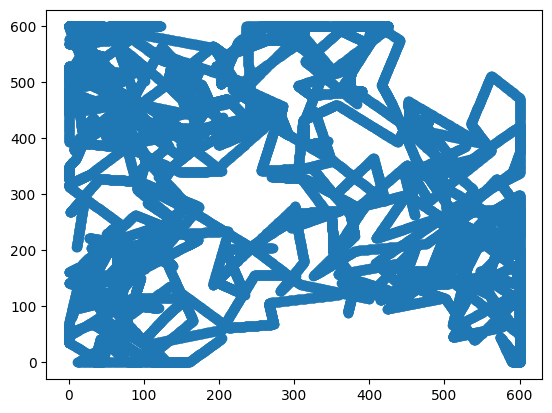

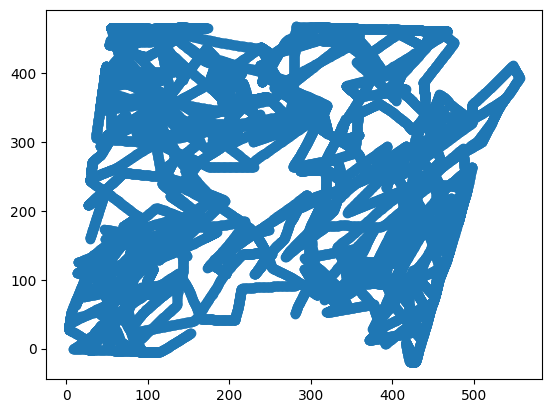

In [4]:
visualize(dataset.get_data(), projection='2d')
visualize(vae(torch.tensor(dataset.get_data()), 'cpu', True, False)[0].detach().cpu().numpy(), projection='2d')

In [16]:
robot = Point([10, 10])
action_space = gym.spaces.Box(low=-1., high=1., shape=(2,), dtype=np.float32)
observation_space = gym.spaces.Box(
    low=np.array([0, 0, -np.inf, -np.inf]),
    high=np.array([600, 600, np.inf, np.inf]),
    shape=(4,),
    dtype=np.float32
)

/home/tsak/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [17]:
env = SimpleEnv(
    robot=robot,
    reward_type='mse',
    target=None,
    n_obs=2,
    goals=dataset.get_data()[[8000, 200]],
    goal_conditioned_policy=True,
    latent_rep=True,
    observation_space=observation_space,
    action_space=action_space,
    random_start=True,
    max_steps=0,
    vae=vae,
    scaler=scaler
)